In [ ]:
!mkdir data
# Download english and french embeddings
!curl -Lo data/wiki.en.vec https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec
!curl -Lo data/wiki.fr.vec https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fr.vec

# Download dictionnary en-fr
!curl -Lo data/dic-en-fr.txt https://dl.fbaipublicfiles.com/arrival/dictionaries/en-fr.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6291M  100 6291M    0     0  13.0M      0  0:08:02  0:08:02 --:--:-- 13.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2886M  100 2886M    0     0  13.6M      0  0:03:31  0:03:31 --:--:-- 13.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1814k  100 1814k    0     0   996k      0  0:00:01  0:00:01 --:--:--  996k


# **SUPERVISED LEARNING :**

For the unsupervised part to work, our functions are in evaluate_utils.py and gan_utils.py and they should be downloaded (they are in the same directory as the notebook)

In [ ]:
import io
import numpy as np
from numpy.linalg import norm
import scipy
import evaluate_utils
import gan_utils

# Function modules

In [ ]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

def cos_sim(a,b):
     return np.dot(a, b)/(norm(a)*norm(b))

def orthogonalize_svd(W):
    U, s, Vh = np.linalg.svd(W)
    return U.dot(Vh)

def align_vectors(dic_path, src_embeddings, tgt_embeddings, src_word2id, tgt_word2id, verbose = 0):
    """
    Returns src_embeddings, tgt_embeddings so that their correspondant lines represent the same word in 
    the two languages
    """
    src = []
    tgt = []
    with io.open(dic_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word_src, word_tgt = line.rstrip().split(' ', 1)
            try :
                word_src_id, word_tgt_id = src_word2id[word_src], tgt_word2id[word_tgt]
                src.append(src_embeddings[word_src_id])
                tgt.append(tgt_embeddings[word_tgt_id])
            except:
                if verbose == 1 :
                  print("Word from dictionnary:", word_src, "or", word_tgt, "is not found in original embeddings")
            
    return np.array(src), np.array(tgt)

def cos_gdt_dst(alpha, x, z, ite):
    """assume nb_words < min(x.shape[0],z.shape[0])"""
    dim = x.shape[1]
    W = np.zeros((dim,dim))
    
    grad = np.zeros((dim,dim))
    for j in range(x.shape[0]):
        grad += np.dot(x[j].reshape(-1,1),z[j].reshape(1,-1))
    
    for i in range(ite):
        W = W + alpha * grad
        W = orthogonalize_svd(W)
    return W

def quad_gdt_dst(alpha, x, z, ite, orth=True,rd=False):
    #Loss function = sum(||Wx_i - z_i||^2)
    #grad = sum((Wx_i-z_i)transp(x_i))
    dim = x.shape[1]
    if rd:
        W = np.random.random((dim,dim))
    else:
        W = np.zeros((dim,dim))
    
    for i in range(ite):
        grad = np.zeros((dim,dim))
        for j in range(x.shape[0]):
            Wx = np.dot(W,x[j])
            grad += np.dot(Wx-z[j],x[j])
            
        W = W + alpha * grad
        if orth: W = orthogonalize_svd(W)
    return W

def evaluate(X,Z):
    cpt, bef_t, aft_t = 0,0,0
    for i in range(X.shape[0]):
        bef_t += cos_sim(X[i],Z[i])
        aft_t += cos_sim(W.dot(X[i]).T,Z[i])
        cpt += 1
    print("Before training :", bef_t/cpt)
    print("After training :", aft_t/cpt)

def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, W, K=5, target=None):
    if target==None: print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = W.dot(src_emb[word2id[word]])
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    if target==None:
        for i, idx in enumerate(k_best):
            print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))
    else:
        for i, idx in enumerate(k_best):
            if tgt_id2word[idx]==target:
                return(i+1)
        return(-1)

def test_ranks(dic_path,W, tgt_emb,tgt_id2word,K=10,sep=' '):

    hist = [0 for k in range(K)]
    count=0
    total=0
    with io.open(dic_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        total += 1
        for i, line in enumerate(f):
            count += 1
            word_src, word_tgt = line.rstrip().split(sep, 1)
            try :
                word_src_id, word_tgt_id = src_word2id[word_src], tgt_word2id[word_tgt]
            except:
                count-=1
            rk = get_nn(word_src,src_embeddings,src_id2word,tgt_emb,tgt_id2word, W, K=K,target=word_tgt)
            if rk>0:
                hist[rk-1]+=1
    return (hist,count)

def procrustes(x, z):
  return orthogonalize_svd((z.T).dot(x))

# Preprocessing (Re-run for unsupervised)

In [ ]:
src_path = 'data/wiki.en.vec'
tgt_path = 'data/wiki.fr.vec'
dic_path = 'data/dic-en-fr.txt'

nmax = 100000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

In [ ]:
# Dicpath should point to a dictionnary going from src language to tgt language
dicpath = 'data/dic-en-fr.txt'
X,Z = align_vectors(dicpath, src_embeddings, tgt_embeddings, src_word2id,tgt_word2id)
# X , Z are now embeddings that are translations of each other line by line

We subdivise our data

In [ ]:
train_size = 0.7
val_size = 0.03
X_train, Z_train = X[:int(X.shape[0]*train_size)], Z[:int(Z.shape[0]*train_size)]
X_val, Z_val = X[int(X.shape[0]*train_size):int(X.shape[0]*(train_size+val_size))], Z[int(X.shape[0]*train_size):int(X.shape[0]*(train_size+val_size))]
X_test, Z_test = X[int(X.shape[0]*(val_size+train_size)):], Z[int(Z.shape[0]*(val_size+train_size)):]

We normalize the previous arrays as it increases performance

In [ ]:
X_train_norm = X_train / norm(X_train, axis = 1).reshape(X_train.shape[0],1)
Z_train_norm = Z_train / norm(Z_train, axis = 1).reshape(Z_train.shape[0],1)

X_test_norm = X_test / norm(X_test, axis = 1).reshape(X_test.shape[0],1)
Z_test_norm = Z_test / norm(Z_test, axis = 1).reshape(Z_test.shape[0],1)

X_val_norm = X_val / norm(X_val, axis = 1).reshape(X_val.shape[0],1)
Z_val_norm = Z_val / norm(Z_val, axis = 1).reshape(Z_val.shape[0],1)

tgt_embeddings_norm = tgt_embeddings / norm(tgt_embeddings, axis = 1).reshape(tgt_embeddings.shape[0],1)
src_embeddings_norm = src_embeddings / norm(src_embeddings, axis = 1).reshape(src_embeddings.shape[0],1)

We test different initializations

In [ ]:
# Test with orthogonalization and zeros initialization
W = quad_gdt_dst(0.5,X_train_norm,Z_train_norm, 500)

# Test without orthogonalization and zeros initialization
W_z_n = quad_gdt_dst(0.005,X_train_norm,Z_train_norm, 50,orth=False)

# Test with orthogonalization and random initialization 
W_r_n = quad_gdt_dst(0.005,X_train_norm,Z_train_norm, 50,orth=False,rd=True)

# Test with orthogonalization and random initialization 
W_r_o = quad_gdt_dst(0.5,X_train_norm,Z_train_norm, 50,rd=True)

# Run algorithm with orthogonalization and zeros initialization 
W_full = quad_gdt_dst(0.5,X_train_norm,Z_train_norm, 500)

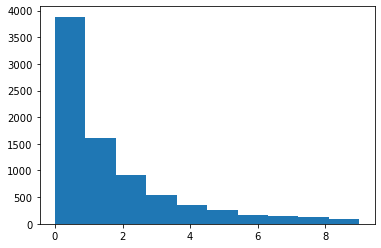

In [ ]:
#H,c = test_ranks('train_en_fr.txt',W,tgt_embeddings,tgt_id2word)


import matplotlib.pyplot as plt

def rank_histogram(L):
    H = []
    for i in range(len(L)):
        H += L[i]*[i]
    plt.hist(H)

rank_histogram(H)

In [ ]:
get_nn("mother",src_embeddings,src_id2word,tgt_embeddings,tgt_id2word,W)

Nearest neighbors of "mother":
0.5865 - mère
0.4739 - sœur
0.4727 - père
0.4691 - tantes
0.4685 - époux


# Training the three methods on normalized and unnormalized inputs

In [ ]:
alpha = 0.05
epochs = 300 

W_grad_cos = cos_gdt_dst(alpha, X_train, Z_train, epochs)
W_grad_cos_norm = cos_gdt_dst(alpha, X_train_norm, Z_train_norm, epochs)

W_grad_quad = quad_gdt_dst(alpha, X_train, Z_train, epochs)
W_grad_quad_norm = quad_gdt_dst(alpha, X_train_norm, Z_train_norm, epochs)

W_procrustes = procrustes(X_train, Z_train)
W_procrustes_norm = procrustes(X_train_norm, Z_train_norm)

Saving arrays (Long training)

In [ ]:
# !mkdir training_results

In [ ]:
# np.save('training_results/W_grad_cos.npy', W_grad_cos)
# np.save('training_results/W_grad_cos_norm.npy', W_grad_cos_norm)
# np.save('training_results/W_grad_quad.npy', W_grad_quad)
# np.save('training_results/W_grad_quad_norm.npy', W_grad_quad_norm)
# np.save('training_results/W_procrustes.npy', W_procrustes)
# np.save('training_results/W_procrustes_norm.npy', W_procrustes_norm)

Loading arrays :

In [ ]:
# W_grad_cos = np.load('training_results/W_grad_cos.npy')
# W_grad_cos_norm = np.load('training_results/W_grad_cos_norm.npy')

# W_grad_quad = np.load('training_results/W_grad_quad.npy')
# W_grad_quad_norm = np.load('training_results/W_grad_quad_norm.npy')

# W_procrustes = np.load('training_results/W_procrustes.npy')
# W_procrustes_norm = np.load('training_results/W_procrustes_norm.npy')


In [ ]:
print("A / Using gradient descent with cosine similarity:\n")

print("A1 / For unnormalized inputs :")
print("Cosine sim for training ", evaluate_cosine(W_grad_cos, X_train, Z_train))
print("Cosine sim for testing ", evaluate_cosine(W_grad_cos, X_test, Z_test))

print("A2 / For normalized inputs :")
print("Cosine sim for training ", evaluate_cosine(W_grad_cos_norm, X_train_norm, Z_train_norm))
print("Cosine sim for testing ", evaluate_cosine(W_grad_cos_norm, X_test_norm, Z_test_norm))
print("\n\n")

#///////////////////////////////////////////////////////////////////////////////////////////////////

print("B / Using gradient descent with Quadratic distance:\n")

print("B1 / For unnormalized inputs :")
print("Cosine sim for training ", evaluate_cosine(W_grad_quad, X_train, Z_train))
print("Cosine sim for testing ", evaluate_cosine(W_grad_quad, X_test, Z_test))

print("B2 / For normalized inputs :")
print("Cosine sim for training ", evaluate_cosine(W_grad_quad_norm, X_train_norm, Z_train_norm))
print("Cosine sim for testing ", evaluate_cosine(W_grad_quad_norm, X_test_norm, Z_test_norm))
print("\n\n")

#///////////////////////////////////////////////////////////////////////////////////////////////////


print("C / Using Procrustes algorithm :\n")

print("For unnormalized inputs :")
print("Cosine sim for training ", evaluate_cosine(W_procrustes, X_train, Z_train))
print("Cosine sim for testing ", evaluate_cosine(W_procrustes, X_test, Z_test))

print("For normalized inputs :")
print("Cosine sim for training ", evaluate_cosine(W_procrustes_norm, X_train_norm, Z_train_norm))
print("Cosine sim for testing ", evaluate_cosine(W_procrustes_norm, X_test_norm, Z_test_norm))

A / Using gradient descent with cosine similarity:

A1 / For unnormalized inputs :
Bef tr : 0.01769880358083903 Aft tr : -0.011446674987884164
Cosine sim for training  None
Bef tr : 0.01781777339407493 Aft tr : -0.009702933532630183
Cosine sim for testing  None
A2 / For normalized inputs :
Bef tr : 0.017698803580839032 Aft tr : -0.009815192026373307
Cosine sim for training  None
Bef tr : 0.017817773394074927 Aft tr : -0.0075203368104261314
Cosine sim for testing  None



B / Using gradient descent with Quadratic distance:

B1 / For unnormalized inputs :
Bef tr : 0.01769880358083903 Aft tr : 0.25515851051604044
Cosine sim for training  None
Bef tr : 0.01781777339407493 Aft tr : 0.25601490176052416
Cosine sim for testing  None
B2 / For normalized inputs :
Bef tr : 0.017698803580839032 Aft tr : 0.2805011377332783
Cosine sim for training  None
Bef tr : 0.017817773394074927 Aft tr : 0.2809639144542358
Cosine sim for testing  None



C / Using Procrustes algorithm :

For unnormalized inputs 

# **UNSUPERVISED LEARING**

# We train our model on 25 epochs and keep the settings that performs best on a small validation part of our dataset (3 %)

In [ ]:
discriminator, generator, gan = gan_utils.compile_gan(initial_learning_rate=0.1, decay_steps=10000, decay_rate=0.98)

val_acc, W_best = gan_utils.train_gan(X_train_norm, tgt_embeddings_norm, X_val_norm, Z_val_norm, discriminator, generator, gan, epochs = 25, batch_size = 32, epoch_size = 4500, dis_steps = 3, beta = 0.001, sm = 0.1, mf = 15000)

Epoch: 0 
      Discriminator Loss: 0.5643410086631775 		 Generator Loss: 0.7758752107620239
      Accuracy of translation on validation set :    0.048285852245292124 %

Epoch: 1 
      Discriminator Loss: 0.6503825187683105 		 Generator Loss: 1.9538800716400146
      Accuracy of translation on validation set :    0.0 %

Epoch: 2 
      Discriminator Loss: 0.47016626596450806 		 Generator Loss: 1.7170531749725342
      Accuracy of translation on validation set :    0.14485755673587639 %

Epoch: 3 
      Discriminator Loss: 0.42470836639404297 		 Generator Loss: 1.4088613986968994
      Accuracy of translation on validation set :    0.1931434089811685 %

Epoch: 4 
      Discriminator Loss: 0.43276673555374146 		 Generator Loss: 1.3499846458435059
      Accuracy of translation on validation set :    5.89087397392564 %

Epoch: 5 
      Discriminator Loss: 0.45119670033454895 		 Generator Loss: 1.1792285442352295
      Accuracy of translation on validation set :    22.88749396426847 %

Epo

In [ ]:
W_best = generator.get_weights()[0]

np.save('W_best.npy', W_best)

np.save('val_acc.npy', val_acc)

# Load best rotation matrix of previously trained model 

In [ ]:
W_best = np.load('W_best.npy')
val_acc = np.load('val_acc.npy')

Text(0, 0.5, 'Accuracy on val')

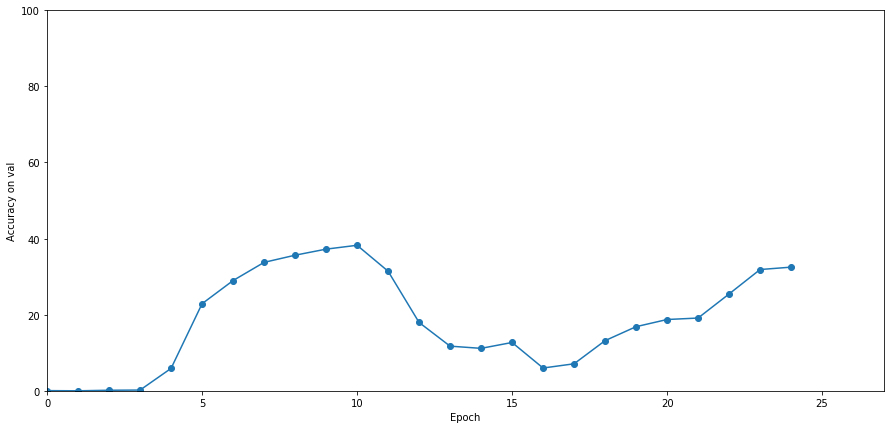

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(list(range(25)), val_acc,'-o')
plt.axis([0, 27, 0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy on val')

# **Plotting accuracy by K-neighbors taken into account in translation:**

In [ ]:
# Due to very heavy computing cost of KNN we take a random sample of indexes of the test to run tests on.
random_indexes = np.random.randint(0,X_test_norm.shape[0],size=2000)
acc = []
for i in range(1,11):
  res = evaluate_utils.accuracy(X_test_norm[random_indexes], Z_test_norm[random_indexes], W_best, tgt_embeddings_norm, i)
  acc.append(res)
  print(f'(K = {i}) Accuracy on test set :{res} %')

(K = 1) Accuracy on test set :33.45 %
(K = 2) Accuracy on test set :42.75 %
(K = 3) Accuracy on test set :48.5 %
(K = 4) Accuracy on test set :52.2 %
(K = 5) Accuracy on test set :54.400000000000006 %
(K = 6) Accuracy on test set :57.25 %
(K = 7) Accuracy on test set :58.550000000000004 %
(K = 8) Accuracy on test set :59.9 %
(K = 9) Accuracy on test set :61.35 %
(K = 10) Accuracy on test set :62.64999999999999 %


Text(0, 0.5, 'Accuracy on test')

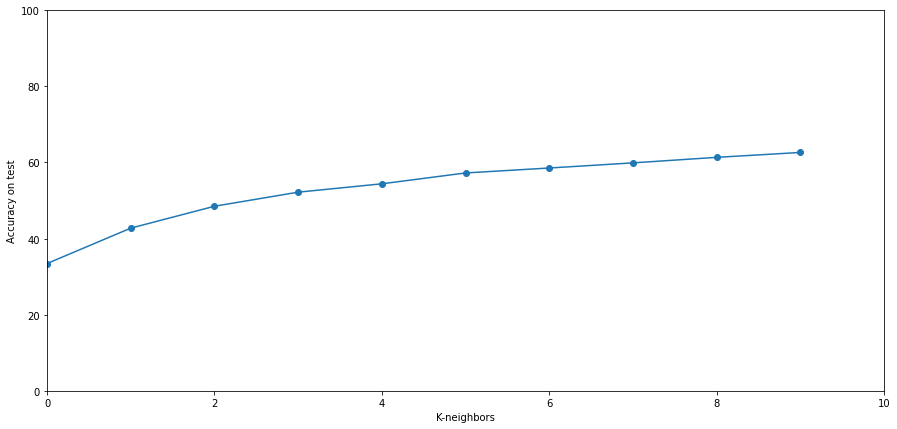

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(list(range(10)), acc,'-o')
plt.axis([0, 10, 0, 100])
plt.xlabel('K-neighbors')
plt.ylabel('Accuracy on test')

# **Examples :**

In [ ]:
evaluate_utils.get_word_nn("network", W_best, src_embeddings_norm,src_id2word,tgt_embeddings_norm,tgt_id2word,K=3)

Nearest neighbors of "network":
    0.6039 - réseau
    0.4837 - réseaux
    0.4662 - maillon


In [ ]:
evaluate_utils.get_word_nn("real", W_best, src_embeddings_norm,src_id2word,tgt_embeddings_norm,tgt_id2word,K=3)

Nearest neighbors of "real":
    0.5230 - réelle
    0.4772 - réel
    0.4722 - vraie


In [ ]:
evaluate_utils.get_word_nn("against", W_best, src_embeddings_norm,src_id2word,tgt_embeddings_norm,tgt_id2word,K=3)

Nearest neighbors of "against":
    0.6731 - contre
    0.5691 - opposant
    0.5684 - affronte


In [ ]:

evaluate_utils.get_word_nn("hello", W_best, src_embeddings_norm,src_id2word,tgt_embeddings_norm,tgt_id2word,K=3)

Nearest neighbors of "hello":
    0.5653 - voilà
    0.5467 - attends
    0.5352 - voilou


In [ ]:
evaluate_utils.get_word_nn("doubt", W_best, src_embeddings_norm,src_id2word,tgt_embeddings_norm,tgt_id2word,K=3)

Nearest neighbors of "doubt":
    0.6547 - douter
    0.6426 - effectivement
    0.6423 - présumer
